In [1]:
import os
import shutil
from pathlib import Path
import mne
import numpy as np
import pandas as pd
import logging
import argparse
import yaml

import torch
from torch import Tensor, nn
from torch.types import Device, _size
from torch.nn.parameter import Parameter, UninitializedParameter
from torch.nn import init
from torch.utils.data import Dataset
from torch.utils.data import ConcatDataset
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from collections import OrderedDict
from fvcore.nn import FlopCountAnalysis, parameter_count_table
import matplotlib.pyplot as plt
from sklearn.preprocessing import Normalizer, StandardScaler
%matplotlib notebook

from models.encoder import res_encoderS
from models.classifier import transformer_classifier


2024-12-05 15:34:16.569778: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-05 15:34:16.590886: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-05 15:34:16.869437: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
logger = logging.getLogger(__name__)  # Use the current module's name
logger.setLevel(logging.DEBUG)
handler = logging.StreamHandler()
# formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
# handler.setFormatter(formatter)
logger.addHandler(handler)
acc_example = 0.95  # Replace with your actual accuracy calculation
logger.info(f"test accuracy: {acc_example}")  # Log as info
# logger.debug("Current accuracy: %.2f", accuracy)  # Log as info

test accuracy: 0.95


In [3]:
parser = argparse.ArgumentParser()
parser.add_argument("config_file", metavar="FILE", help="config file")
# parser.add_argument('--run-dir', metavar='DIR', help='run directory')
# parser.add_argument('--pdb', action='store_true', help='pdb')
args = parser.parse_args(args=['configs/encoderS+transformer.yml'])
with open(args.config_file, 'r') as file:
    Configs = yaml.safe_load(file)
    

In [4]:
class customDataset(Dataset):
    def __init__(self, data_dir:str, label_dir:str, label_dict:dict, transform=None):
#         self.annotations = pd.read_csv(label_dir)
        self.data_dir = data_dir   # './data/origin_csv/train'
        self.label_dir = label_dir
        self.transform = transform
        self.files = os.listdir(self.data_dir)
        self.annotations = pd.read_csv(self.label_dir)
        self.label_dict = label_dict
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, index):
        data_path = os.path.join(self.data_dir, self.files[index])
        data = pd.read_csv(data_path)
        data = torch.tensor(data.values, dtype=torch.float32)
        file_name = self.files[index]
        
        label = torch.tensor(int(self.label_dict[self.annotations.iloc[index,1]]))
        
        if self.transform:
            data = self.transform(data)
            
        return (data.t(), label, file_name)


In [5]:
class model(nn.Module):
    def __init__(self, input_size: int, n_channels: int, model_hyp: dict, classes: int):
        super(model, self).__init__()
        self.ae = res_encoderS(n_channels=n_channels, groups=n_channels, num_classes=classes, 
                               len_feature=input_size, d_model=model_hyp['d_model'])
#         self.transformer_encoder = transformer_classifier(input_size, n_channels, model_hyp, classes)
        self.transformer_encoder = transformer_classifier(input_size, n_channels, model_hyp, classes)
        
        self.reset_parameters()
        
    def reset_parameters(self):
        r"""Initiate parameters in the model."""
        
        for p in self.parameters():
            if p.dim() > 1:
#                 logger.debug(p.shape)
                nn.init.xavier_uniform_(p)
                    
        for m in self.modules():
#             print(m)
            if isinstance(m, nn.Conv1d):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
        
            elif isinstance(m, (nn.LayerNorm, nn.BatchNorm1d)):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
        print('Complete initiate parameters')

    def forward(self, x):
#         z = self.pe(x)
#         z = x.transpose(-1,-2)
        z = self.ae(x)
#         z = torch.flatten(z, 1)
#         y = self.mlp(z)
        y = self.transformer_encoder(z)
        return y
        
# classifier = model(input_size=Configs['input_size'],
#                                         n_channels = Configs['n_channels'],
#                                         model_hyp=Configs['model'],
#                                         classes=len(Configs['dataset']['classes'])).to('cuda')


In [6]:
# train_data_dir = Configs['dataset']['train_data_dir']
# train_label_dir = Configs['dataset']['train_label_dir']

test_eval_data_dir = '../results/test_data'
test_eval_label_dir = '../results/result_eval_12000.csv'

label_dict = Configs['dataset']['classes']
# train_dataset = customDataset(data_dir=train_data_dir,
#                               label_dir=train_label_dir,
#                               label_dict=label_dict)
test_eval_dataset = customDataset(data_dir=test_eval_data_dir,
                            label_dir=test_eval_label_dir,
                            label_dict=label_dict)

test_eval_loader = DataLoader(dataset=test_eval_dataset, pin_memory=True,shuffle=False)

In [7]:
classifier = torch.load('../2411252344_encoderS+transformer_params_epoch_2_bestacc0.791252.pth')
classifier.eval()

model(
  (ae): AutoEncoder(
    (conv1): Conv1d(19, 152, kernel_size=(64,), stride=(2,), padding=(3,), groups=19, bias=False)
    (avgpool1d): AdaptiveAvgPool1d(output_size=6000)
    (ln1): LayerNorm((6000,), eps=1e-05, elementwise_affine=True)
    (relu): ReLU(inplace=True)
    (avgpool_1): AvgPool1d(kernel_size=(3,), stride=(2,), padding=(1,))
    (layers): ModuleList(
      (0): Sequential(
        (0): BasicBlock(
          (conv1): Conv1d(152, 152, kernel_size=(16,), stride=(1,), padding=(1,), groups=19, bias=False)
          (avgpool_1): AdaptiveAvgPool1d(output_size=3000)
          (ln1): LayerNorm((3000,), eps=1e-05, elementwise_affine=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv1d(152, 152, kernel_size=(16,), stride=(1,), padding=(1,), groups=19, bias=False)
          (avgpool_2): AdaptiveAvgPool1d(output_size=3000)
          (ln2): LayerNorm((3000,), eps=1e-05, elementwise_affine=True)
        )
        (1): BasicBlock(
          (conv1): Conv1d(152, 152

In [8]:
# optimizer = torch.optim.Adam(classifier.parameters(),betas=(0.9,0.9),lr=Configs['optimizer']['init_lr'])
criterion = nn.CrossEntropyLoss()
# writer = SummaryWriter(Configs['tensorboard']['runs_dir']+'visulizer')    # Initilize tensorflow

dataiter = iter(test_eval_loader)

In [9]:
signal, labels,file_name = next(dataiter)
signal, target = signal.to('cuda'), labels.to('cuda')

In [10]:
file_name 

['aaaaakmg_s003_t001_4_abnormal.csv']

### Save representation

In [11]:
train_feature_maps = []  # Reset feature maps for the new epoch
eval_feature_maps = []  # Reset feature maps for the new epoch
# Define a folder to save feature maps
output_folder = 'feature_maps'
os.makedirs(output_folder, exist_ok=True)

# Hook function to save feature maps
# feature_maps = []

def train_hook_fn(module, input, output):
    train_feature_maps.append(output)

def eval_hook_fn(module, input, output):
    eval_feature_maps.append(output)

# Function to save feature maps as images
def save_feature_maps_as_images(feature_maps, epoch, output_folder):
    for idx, fmap in enumerate(feature_maps):
        fmap = fmap.detach().cpu().numpy()  # Convert to numpy array
        num_channels = fmap.shape[1]
        for channel in range(num_channels):
            plt.imshow(fmap[0, channel], cmap='viridis')  # Display one feature map channel
            plt.colorbar()
            plt.title(f'Epoch {epoch}, Feature Map {idx + 1}, Channel {channel + 1}')
            plt.savefig(os.path.join(output_folder, f'epoch_{epoch}_feature_map_{idx+1}_channel_{channel+1}.png'))
            plt.close()

#### Save similarity matrix

In [12]:
# Function to hook and save intermediate feature maps
def hook_fn(module, input, output):
    global attention_map
    attention_map = output  # Save the attention map (19x19 for self-attention)
    
attention_map = None  # Global variable to store the hooked output
hook = classifier.transformer_encoder.encoder_layer.self_attn.register_forward_hook(hook_fn)

output = classifier(signal)

# The attention map is now stored in the global variable `attention_map`
# print(f"Attention feature map shape: {attention_map.shape}")  
hook.remove()

/home/yossi/anaconda3/envs/python38/lib/python3.8/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608851799/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,


In [13]:
attention_map

In [14]:
hook

In [15]:
hook0 = classifier.ae.avgpool_2.register_forward_hook(train_hook_fn)
# hook1 = classifier.transformer_encoder.encoder_layer.register_forward_hook(train_hook_fn)


out = classifier(signal)
loss = criterion(out, target)
probabilities = torch.softmax(out, dim=1)  # Apply softmax to get probabilities
_, predicted = torch.max(probabilities, 1)

print(out)
print(probabilities)
print(target)
print(loss)
print(predicted)

tensor([[-0.3150,  0.1298]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[0.3906, 0.6094]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([1], device='cuda:0')
tensor(0.4953, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor([1], device='cuda:0')


In [16]:
column_names = ['Fp1', 'Fp2', 'F3','F4', 'C3F', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8','T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']

In [17]:
features = train_feature_maps[0][0].t().to('cpu').detach()
df = pd.DataFrame(features.numpy(), columns=column_names)
csv_filename = "../results/autoencoder_data_abnormal.csv"
df.to_csv(csv_filename, index=False) 

In [18]:
file_name

['aaaaakmg_s003_t001_4_abnormal.csv']

### Plot representation

In [19]:
import os
import shutil
from pathlib import Path
import mne
import numpy as np
import pandas as pd
import logging
import argparse
import yaml

In [20]:
data1 = pd.read_csv('../results/test_data/aaaaakmg_s003_t001_4_abnormal.csv')
data2 = pd.read_csv('../results/autoencoder_data_abnormal.csv')

In [21]:
selected_channels = ['F3', 'Cz', 'F4']
data1_selected = data1[selected_channels]
data2_selected = data2[selected_channels]

In [22]:
# Time vectors
time1 = np.linspace(0, 120, data1.shape[0])  # For 120 seconds
time2 = np.linspace(0, 120, data2.shape[0])  # For 120 seconds (resampled)

<IPython.core.display.Javascript object>


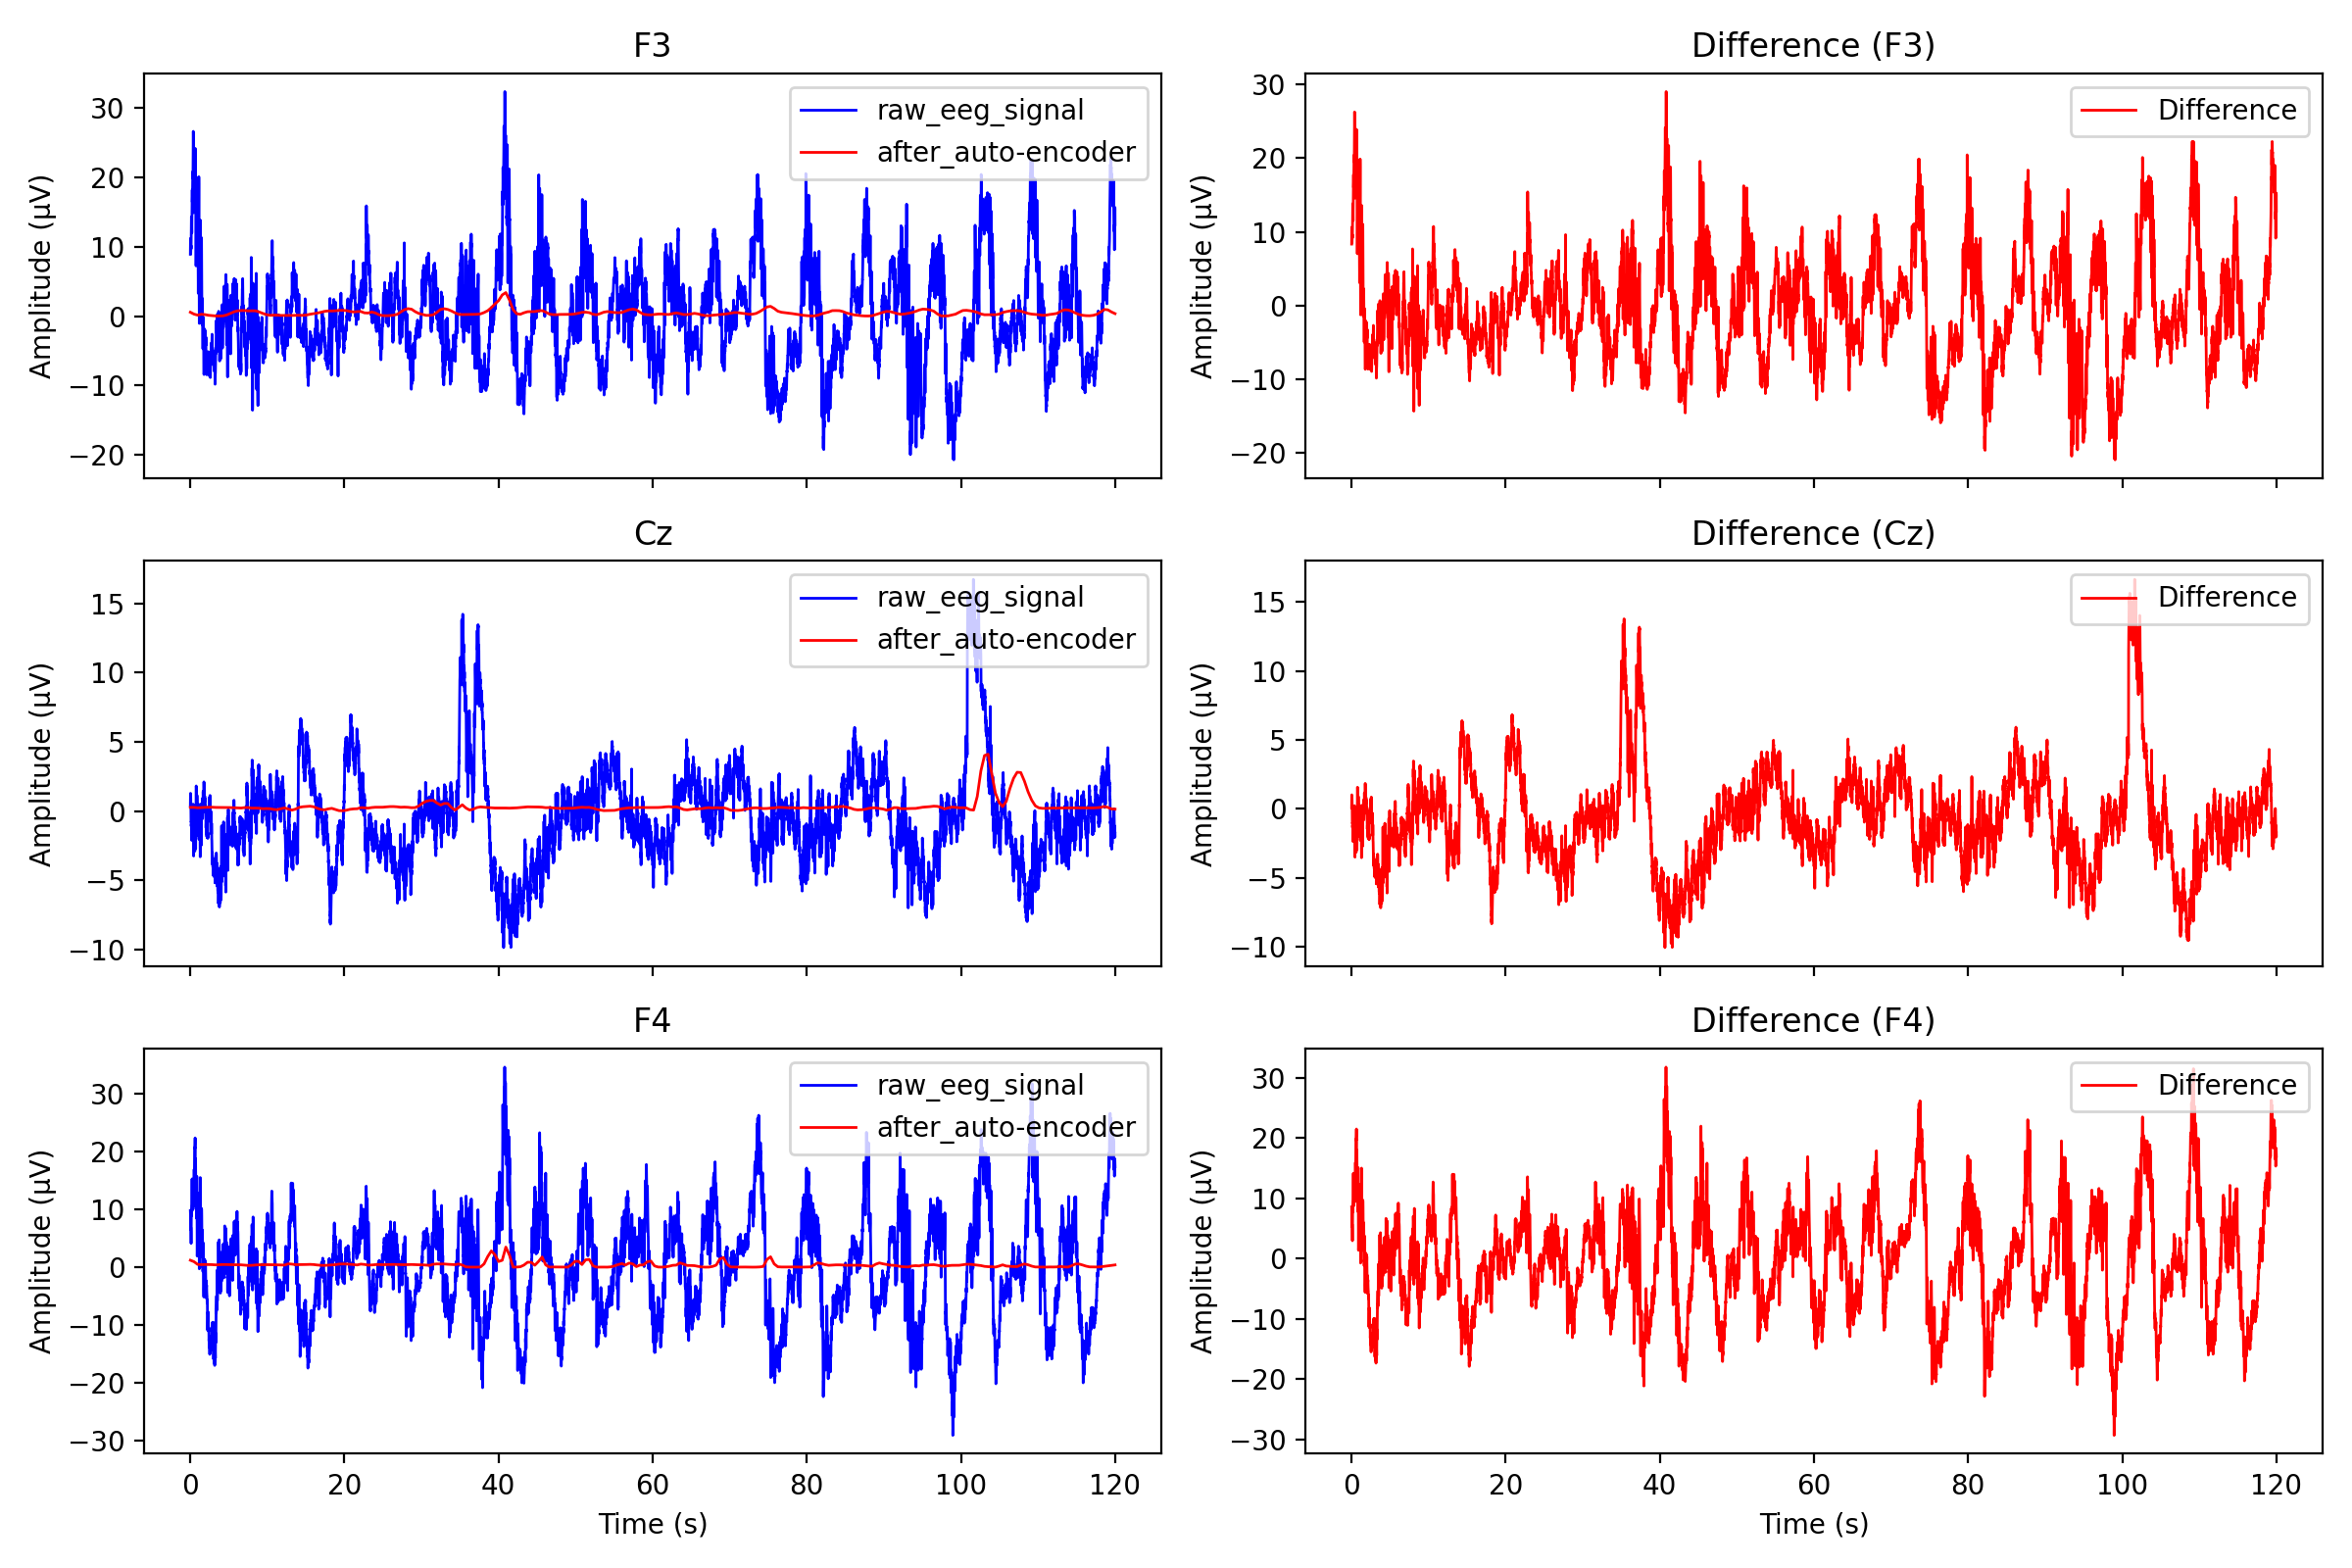

In [27]:
selected_channels = ['F3', 'Cz', 'F4']
data1_selected = data1[selected_channels]
data2_selected = data2[selected_channels]

### Plot spectrums

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import spectrogram

# Load data
file1 = "../results/test_data/aaaaakmg_s003_t001_4_abnormal.csv"  # Replace with the benign file path
file2 = "../results/autoencoder_data_abnormal.csv"  # Replace with the filtered file path

# Read CSV files
data_benign = pd.read_csv(file1)  # Shape: (12000, 19)
data_filtered = pd.read_csv(file2)  # Shape: (256, 19)

# Channels to plot
selected_channels = ["F3", "Cz", "F4"]  # Replace with actual channel names

# Sampling frequencies
fs_benign = 100  # Sampling frequency for benign signals
fs_filtered = 100  # Sampling frequency for filtered signals

# Plot spectrograms
fig, axes = plt.subplots(len(selected_channels), 3, figsize=(15, 10), constrained_layout=True)

for i, channel in enumerate(selected_channels):
    # Extract channel signals
    signal_benign = data_benign[channel].values
    signal_filtered = data_filtered[channel].values

    # Compute spectrograms
    f_benign, t_benign, Sxx_benign = spectrogram(signal_benign, fs=fs_benign, nperseg=256, noverlap=128)
    f_filtered, t_filtered, Sxx_filtered = spectrogram(signal_filtered, fs=fs_filtered, nperseg=256, noverlap=128)

    # Adjust the time axis to match 0-120s
    t_benign = np.linspace(0, 120, len(t_benign))  # Force time to 0-120s
    t_filtered = np.linspace(0, 120, len(t_filtered))  # Force time to 0-120s
    min_length = min(Sxx_benign.shape[1], Sxx_filtered.shape[1])
    Sxx_difference = Sxx_benign[:, :min_length] - Sxx_filtered[:, :min_length]
    t_diff = np.linspace(0, 120, min_length)  # Adjust difference time to 0-120s

    # Set color limits for consistency
    vmin, vmax = -40, 0  # Adjust these values to better match the template

    # Plot benign spectrogram
    ax = axes[i, 0]
    pcm = ax.pcolormesh(t_benign, f_benign, 10 * np.log10(Sxx_benign), shading='gouraud', cmap='jet', vmin=vmin, vmax=vmax)
    fig.colorbar(pcm, ax=ax, label="Power (dB)")
    ax.set_title(f"{channel} - Benign")
    ax.set_ylabel("Frequency (Hz)")
    ax.set_xlabel("Time (s)")
    ax.set_xlim(0, 120)

    # Plot filtered spectrogram
    ax = axes[i, 1]
    pcm = ax.pcolormesh(t_filtered, f_filtered, 10 * np.log10(Sxx_filtered), shading='gouraud', cmap='jet', vmin=vmin, vmax=vmax)
    fig.colorbar(pcm, ax=ax, label="Power (dB)")
    ax.set_title(f"{channel} - Filtered")
    ax.set_ylabel("Frequency (Hz)")
    ax.set_xlabel("Time (s)")
    ax.set_xlim(0, 120)

    # Plot difference spectrogram
    ax = axes[i, 2]
    pcm = ax.pcolormesh(t_diff, f_benign, Sxx_difference, shading='gouraud', cmap='jet')
    fig.colorbar(pcm, ax=ax, label="Difference Power")
    ax.set_title(f"{channel} - Difference")
    ax.set_ylabel("Frequency (Hz)")
    ax.set_xlabel("Time (s)")
    ax.set_xlim(0, 120)

# Show the updated plots
plt.show()
# Uncomment below line to save the figure
# plt.savefig('../results/spectrums_fixed.png')

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import spectrogram

# Load data
file1 = "../results/test_data/aaaaakmg_s003_t001_4_abnormal.csv"  # Replace with the benign file path

# Read CSV file
data_benign = pd.read_csv(file1)  # Shape: (12000, 19)

# Channels to plot
selected_channels = ["F3", "Cz", "F4"]  # Replace with actual channel names

# Sampling frequency
fs_benign = 100  # Sampling frequency for benign signals

# Adjust figure size to make plots rectangular
fig, axes = plt.subplots(len(selected_channels), 1, figsize=(16, 6 * len(selected_channels)), constrained_layout=True)

for i, channel in enumerate(selected_channels):
    # Extract channel signal
    signal_benign = data_benign[channel].values

    # Debug signal length
    print(f"{channel} - Raw signal length: {len(signal_benign)}")

    # Compute spectrogram
    f_benign, t_benign, Sxx_benign = spectrogram(signal_benign, fs=fs_benign, nperseg=256, noverlap=128)

    # Adjust the time axis to 0-120 seconds
    t_benign = np.linspace(0, 120, len(t_benign))

    # Set color limits for consistency
    vmin, vmax = -40, 0  # Adjust these values as needed

    # Plot benign spectrogram
    ax = axes[i]
    pcm = ax.pcolormesh(t_benign, f_benign, 10 * np.log10(Sxx_benign), shading='gouraud', cmap='jet', vmin=vmin, vmax=vmax)
    fig.colorbar(pcm, ax=ax, label="Power (dB)")
    ax.set_title(f"{channel} - spectrogram")
    ax.set_ylabel("Frequency (Hz)")
    ax.set_xlabel("Time (s)")
    ax.set_xlim(0, 120)

# Show the plots
plt.show()
# Uncomment the line below to save the figure
plt.savefig('../results/benign_spectrograms_rectangular.png')

In [ ]:
signal_benign.shape, f_benign.shape, t_benign.shape, Sxx_benign.shape

In [ ]:
signal_filtered.shape, f_filtered.shape, t_filtered.shape, Sxx_filtered.shape

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

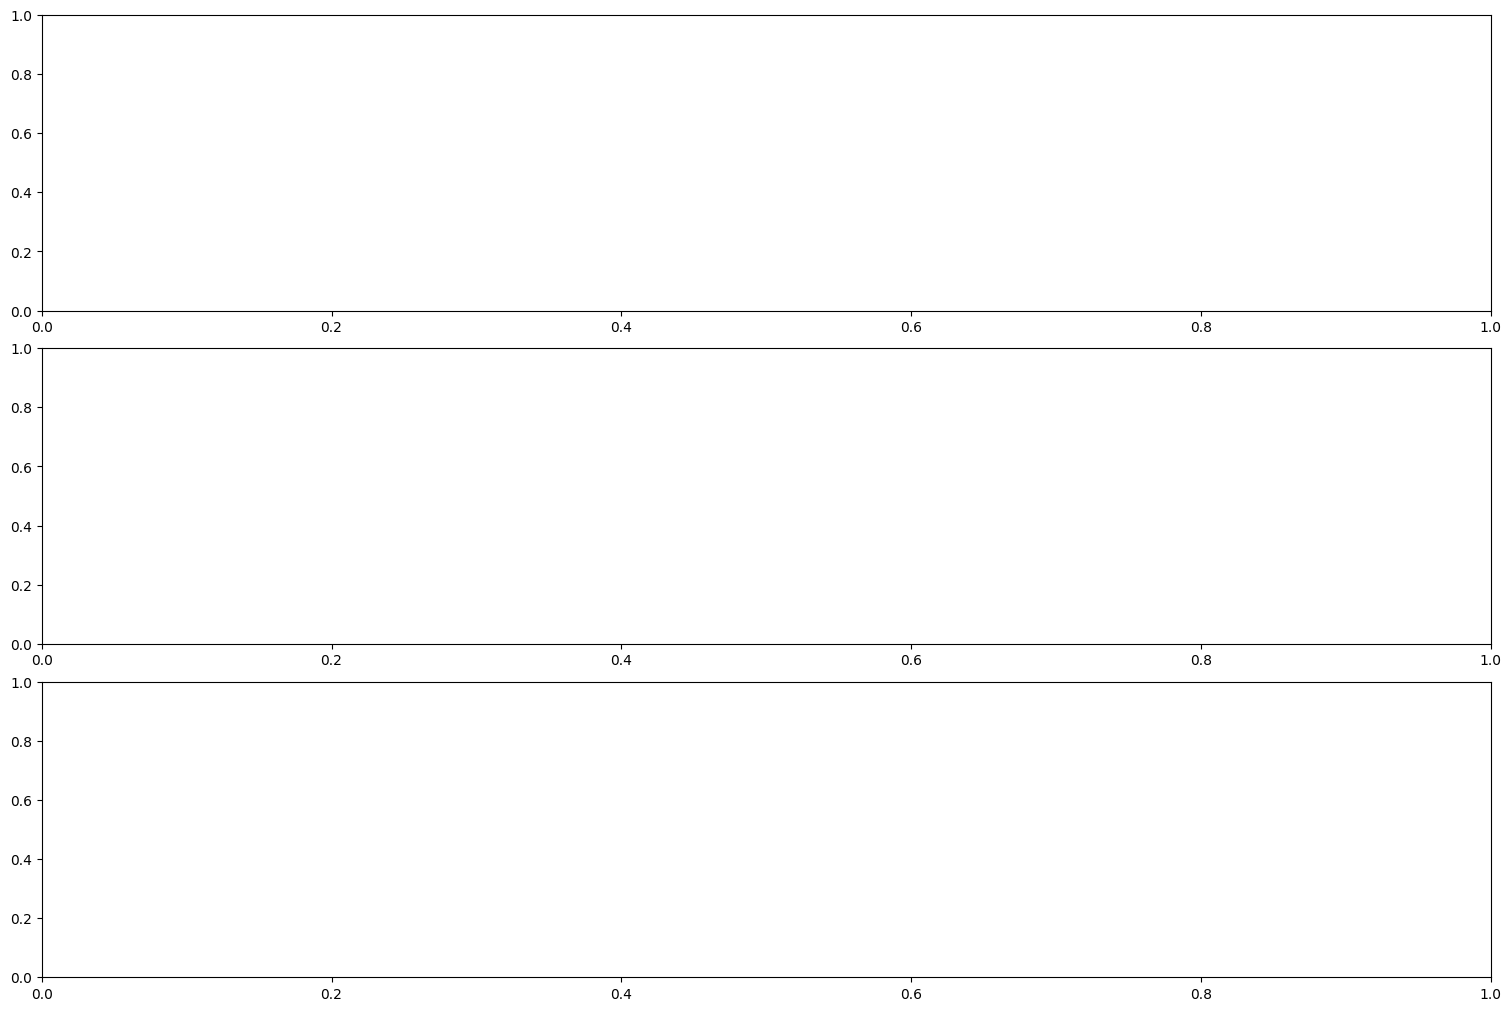

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import spectrogram

# Load data
file1 = "../results/test_data/aaaaakmg_s003_t001_4_abnormal.csv"  # Replace with the benign file path
file2 = "../results/autoencoder_data_abnormal.csv"  # Replace with the filtered file path

# Read CSV files
data_benign = pd.read_csv(file1)  # Shape: (12000, 19)
data_filtered = pd.read_csv(file2)  # Shape: (256, 19)

# Channels to plot
selected_channels = ["F3", "Cz", "F4"]  # Replace with actual channel names

# Sampling frequencies
fs_benign = 100  # Sampling frequency for benign signals
fs_filtered = 100  # Sampling frequency for filtered signals

# Plot spectrograms
fig, axes = plt.subplots(len(selected_channels), 1, figsize=(15, 10), constrained_layout=True)

for i, channel in enumerate(selected_channels):
    # Extract channel signals
    signal_benign = data_benign[channel].values
    signal_filtered = data_filtered[channel].values

    # Compute spectrograms
    f_benign, t_benign, Sxx_benign = spectrogram(signal_benign, fs=fs_benign, nperseg=256, noverlap=128)
    f_filtered, t_filtered, Sxx_filtered = spectrogram(signal_filtered, fs=fs_filtered, nperseg=256, noverlap=128)

    # Adjust the time axis to match 0-120s
    t_benign = np.linspace(0, 120, len(t_benign))  # Force time to 0-120s
    t_filtered = np.linspace(0, 120, len(t_filtered))  # Force time to 0-120s
    min_length = min(Sxx_benign.shape[1], Sxx_filtered.shape[1])
    Sxx_difference = Sxx_benign[:, :min_length] - Sxx_filtered[:, :min_length]
    t_diff = np.linspace(0, 120, min_length)  # Adjust difference time to 0-120s

    # Set color limits for consistency
    vmin, vmax = -40, 0  # Adjust these values to better match the template

    # Plot benign spectrogram
    ax = axes[i, 0]
    pcm = ax.pcolormesh(t_benign, f_benign, 10 * np.log10(Sxx_benign), shading='gouraud', cmap='jet', vmin=vmin, vmax=vmax)
    fig.colorbar(pcm, ax=ax, label="Power (dB)")
    ax.set_title(f"{channel}")
    ax.set_ylabel("Frequency (Hz)")
    ax.set_xlabel("Time (s)")
    ax.set_xlim(0, 120)

    # Plot filtered spectrogram
#     ax = axes[i, 1]
#     pcm = ax.pcolormesh(t_filtered, f_filtered, 10 * np.log10(Sxx_filtered), shading='gouraud', cmap='jet', vmin=vmin, vmax=vmax)
#     fig.colorbar(pcm, ax=ax, label="Power (dB)")
#     ax.set_title(f"{channel} - Filtered")
#     ax.set_ylabel("Frequency (Hz)")
#     ax.set_xlabel("Time (s)")
#     ax.set_xlim(0, 120)

# Show the updated plots
plt.show()
# Uncomment below line to save the figure
# plt.savefig('../results/spectrums.png')